**Connexion à Google Drive pour accéder a la Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importation des bibliothèques nécessaires**

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
import warnings

**Chemins et paramètres de base**


In [5]:
dataset_path = '/content/drive/My Drive/Dataset/Dataset'
output_image_size = (224, 224)  # Taille des images (hauteur, largeur)
batch_size = 32  # Taille des batchs


**Générateur de données pour l'augmentation d'images**


In [6]:
# Générateur de données avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalisation des pixels entre 0 et 1
    rotation_range=20,  # Rotation aléatoire jusqu'à 20 degrés
    width_shift_range=0.2,  # Décalage horizontal jusqu'à 20%
    height_shift_range=0.2,  # Décalage vertical jusqu'à 20%
    shear_range=0.2,  # Cisaillement aléatoire
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Flip horizontal
    validation_split=0.2  # Fraction des données pour validation
)


**Générateur pour l'ensemble d'entraînement**


In [7]:
# Générateur pour les données d'entraînement
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=output_image_size,
    batch_size=batch_size,
    class_mode='categorical',  # 'categorical' pour classification multi-classes
    subset='training'  # Sous-ensemble d'entraînement
)

Found 13194 images belonging to 151 classes.


**Générateur pour l'ensemble de validation**


In [20]:
# Générateur pour les données de validation
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=output_image_size,
    batch_size=batch_size,
    class_mode='categorical',  # 'categorical' pour classification multi-classes
    subset='validation'  # Sous-ensemble de validation
)

# Affichage des classes détectées
print("Classes trouvées :", train_generator.class_indices)

Found 3216 images belonging to 151 classes.
Classes trouvées : {'Abra': 0, 'Aerodactyl': 1, 'Alakazam': 2, 'Arbok': 3, 'Arcanine': 4, 'Articuno': 5, 'Beedrill': 6, 'Bellsprout': 7, 'Blastoise': 8, 'Bulbasaur': 9, 'Butterfree': 10, 'Caterpie': 11, 'Chansey': 12, 'Charizard': 13, 'Charmander': 14, 'Charmeleon': 15, 'Clefable': 16, 'Clefairy': 17, 'Cloyster': 18, 'Cubone': 19, 'Dewgong': 20, 'Diglett': 21, 'Ditto': 22, 'Dodrio': 23, 'Doduo': 24, 'Dragonair': 25, 'Dragonite': 26, 'Dratini': 27, 'Drowzee': 28, 'Dugtrio': 29, 'Eevee': 30, 'Ekans': 31, 'Electabuzz': 32, 'Electrode': 33, 'Exeggcute': 34, 'Exeggutor': 35, "Farfetch'd": 36, 'Fearow': 37, 'Flareon': 38, 'Gastly': 39, 'Gengar': 40, 'Geodude': 41, 'Gloom': 42, 'Golbat': 43, 'Goldeen': 44, 'Golduck': 45, 'Golem': 46, 'Graveler': 47, 'Grimer': 48, 'Growlithe': 49, 'Gyarados': 50, 'Haunter': 51, 'Hitmonchan': 52, 'Hitmonlee': 53, 'Horsea': 54, 'Hypno': 55, 'Ivysaur': 56, 'Jigglypuff': 57, 'Jolteon': 58, 'Jynx': 59, 'Kabuto': 60, 'Kabu

**Visualisation de l'equilibrage des classes de notre dataset**

In [22]:
from sklearn.utils import class_weight
import numpy as np

# Calculer les poids pour chaque classe
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Méthode pour équilibrer
    classes=np.unique(train_generator.classes),  # Les classes présentes
    y=train_generator.classes  # Distribution des classes
)

# Convertir les poids en dictionnaire
class_weights = dict(enumerate(class_weights))
print("Class weights :", class_weights)


Class weights : {0: 1.820364238410596, 1: 1.016017249345449, 2: 1.5886815171583384, 3: 0.9708609271523179, 4: 0.7801561021759698, 5: 0.8737748344370861, 6: 0.8737748344370861, 7: 0.9497552548229197, 8: 0.8483250819777535, 9: 0.5984759139980041, 10: 0.6934720908230843, 11: 0.8166119948010151, 12: 0.910182119205298, 13: 1.0402081362346263, 14: 0.7103860442577936, 15: 0.8737748344370861, 16: 1.1202241467142129, 17: 1.2306687808973042, 18: 1.2135761589403973, 19: 0.740487147828039, 20: 1.0922185430463576, 21: 1.2849629918192442, 22: 1.2849629918192442, 23: 1.1650331125827815, 24: 1.4324177613722724, 25: 1.0402081362346263, 26: 0.891606973915394, 27: 1.1202241467142129, 28: 1.1650331125827815, 29: 1.1202241467142129, 30: 0.9497552548229197, 31: 0.9197629836179854, 32: 1.016017249345449, 33: 1.6181015452538632, 34: 0.9817694768956023, 35: 1.1807768032933597, 36: 1.1807768032933597, 37: 1.1060440942241596, 38: 0.8401681100356597, 39: 0.9197629836179854, 40: 0.9708609271523179, 41: 1.266340339

**Extraction d'un Batch pour l'Entraînement et le Test**

In [23]:
# Extraire un batch pour l'entraînement
x_train, y_train = next(train_generator)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

# Extraire un batch pour la validation
x_test, y_test = next(validation_generator)
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")



x_train shape: (32, 224, 224, 3), y_train shape: (32, 151)
x_test shape: (32, 224, 224, 3), y_test shape: (32, 151)


In [24]:
import numpy as np

# Récupération de plusieurs lots pour l'entraînement et la validation
num_batches = 20  # Augmenté de 5 à 20 pour inclure plus d'échantillons de toutes les classes
x_train_batches = []
y_train_batches = []
x_val_batches = []
y_val_batches = []

# Boucle pour récupérer les lots
for _ in range(num_batches):
    # Récupération d'un lot d'entraînement
    x_batch, y_batch = next(train_generator)
    x_train_batches.append(x_batch)
    y_train_batches.append(y_batch)

    # Récupération d'un lot de validation
    x_batch, y_batch = next(validation_generator)
    x_val_batches.append(x_batch)
    y_val_batches.append(y_batch)

# Concaténation des lots pour former les ensembles d'entraînement et de validation
x_train = np.concatenate(x_train_batches)
y_train = np.concatenate(y_train_batches)
x_test = np.concatenate(x_val_batches)
y_test = np.concatenate(y_val_batches)

# Maintenant, on peut procéder à la division train_test_split
from sklearn.model_selection import train_test_split
# Division des données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(
     x_train, y_train, test_size=0.2, random_state=42
 )

**Modeles pré-entrainés**

**ResNet50**

In [25]:
# Importation des bibliothèques nécessaires
from tensorflow.keras.applications import ResNet50  # Modèle pré-entraîné ResNet50
from tensorflow.keras.models import Model  # Pour personnaliser le modèle
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense  # Couches personnalisées
from tensorflow.keras.optimizers import Adam  # Optimiseur pour entraîner le modèle
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Prétraitement des données
from sklearn.utils import class_weight  # Calcul des poids pour les classes déséquilibrées
import numpy as np


# Chargement du modèle ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajout des couches personnalisées
Y = base_model.output
Y = GlobalAveragePooling2D()(Y)  # Pooling global pour réduire les dimensions
Y = Dense(1024, activation='relu')(Y)  # Couche dense avec 1024 neurones
predictions = Dense(train_generator.num_classes, activation='softmax')(Y)  # Couche de sortie pour la classification

# Création du modèle final
model = Model(inputs=base_model.input, outputs=predictions)





**Fonction de train**

In [26]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np

def train_ResNet50(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=32, learning_rate=0.0001):
    """
    Fonction pour entraîner et évaluer un modèle ResNet50.
    """
    # Étape 1 : Vérifiez et corrigez les labels
    num_classes = model.output_shape[-1]  # Nombre de classes que le modèle doit prédire
    if y_train.shape[-1] != num_classes:
        y_train = to_categorical(y_train, num_classes=num_classes)
    if y_test.shape[-1] != num_classes:
        y_test = to_categorical(y_test, num_classes=num_classes)


    # Étape 2 : Compilation du modèle
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\n=== Début de l'entraînement du modèle ResNet50 ===\n")

    # Étape 3 : Entraînement
    history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights,
    verbose=2
)


    print("\n=== Évaluation du modèle sur l'ensemble de test ===\n")

    # Étape 4 : Évaluation
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
    print(f"Précision sur l'ensemble de test : {test_accuracy * 100:.2f}%")
    print(f"Perte sur l'ensemble de test : {test_loss:.4f}")

    return history, test_loss, test_accuracy

In [27]:
history, test_loss, test_accuracy = train_ResNet50(model, x_train, y_train, x_test, y_test, epochs=20, batch_size=32)



=== Début de l'entraînement du modèle ResNet50 ===

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


413/413 - 4592s - 11s/step - accuracy: 0.7015 - loss: 1.4765 - val_accuracy: 0.0597 - val_loss: 4.5969
Epoch 2/20
413/413 - 2173s - 5s/step - accuracy: 0.9317 - loss: 0.2600 - val_accuracy: 0.8719 - val_loss: 0.4954
Epoch 3/20
413/413 - 2212s - 5s/step - accuracy: 0.9525 - loss: 0.1760 - val_accuracy: 0.9518 - val_loss: 0.1838
Epoch 4/20
413/413 - 2227s - 5s/step - accuracy: 0.9608 - loss: 0.1393 - val_accuracy: 0.9630 - val_loss: 0.1376
Epoch 5/20
413/413 - 2213s - 5s/step - accuracy: 0.9678 - loss: 0.1115 - val_accuracy: 0.9708 - val_loss: 0.1176
Epoch 6/20
413/413 - 2173s - 5s/step - accuracy: 0.9704 - loss: 0.1100 - val_accuracy: 0.9680 - val_loss: 0.1424
Epoch 7/20
413/413 - 2271s - 5s/step - accuracy: 0.9742 - loss: 0.0942 - val_accuracy: 0.9350 - val_loss: 0.2551
Epoch 8/20
413/413 - 2261s - 5s/step - accuracy: 0.9715 - loss: 0.1007 - val_accuracy: 0.9350 - val_loss: 0.2837
Epoch 9/20
413/413 - 2266s - 5s/step - accuracy: 0.9709 - loss: 0.1016 - val_accuracy: 0.9680 - val_loss: 

**Sauvegarder le modéle finale**

In [28]:

model.save('Resnet50.keras')
print("Le modèle a été sauvegardé sous le nom : Resnet50_modele_entraine.h5")

Le modèle a été sauvegardé sous le nom : Resnet50_modele_entraine.h5


**Evaluation des performances du modéle**

In [29]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm.auto import tqdm

def analyze_model_performance(validation_generator, trained_model):
    """
    Analyse les performances du modèle sur le générateur de validation.

    Parameters:
        validation_generator: ImageDataGenerator pour la validation
        trained_model: Modèle DenseNet121 entraîné
    """
    # Get class names from the generator
    class_names = list(validation_generator.class_indices.keys())

    # Initialize arrays for predictions and true labels
    predictions = []
    true_labels = []

    print("Evaluating model performance...")

    # Predict on validation data
    steps = validation_generator.n // validation_generator.batch_size + 1
    for i in tqdm(range(steps)):
        try:
            # Get batch
            x, y = next(validation_generator)
            # Get predictions
            batch_predictions = trained_model.predict(x, verbose=0)
            # Store results
            predictions.extend(batch_predictions)
            true_labels.extend(y)
        except StopIteration:
            break

    # Convert to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Get predicted and true classes
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    # Calculate and display overall accuracy
    overall_accuracy = accuracy_score(true_classes, predicted_classes)
    print(f'\nPrécision globale : {overall_accuracy * 100:.2f}%')

    # Generate and display classification report
    report = classification_report(true_classes, predicted_classes,
                                 target_names=class_names)
    print("\nRapport de classification :\n")
    print(report)

    # Calculate and display per-class accuracy
    print("\nPrécision par classe :\n")
    class_accuracy = {}
    for idx, class_name in enumerate(class_names):
        class_indices = [i for i, true_label in enumerate(true_classes)
                        if true_label == idx]
        if class_indices:
            correct_for_class = accuracy_score(
                [true_classes[i] for i in class_indices],
                [predicted_classes[i] for i in class_indices]
            )
            class_accuracy[class_name] = correct_for_class
            print(f'{class_name}: {correct_for_class * 100:.2f}%')

# Usage
analyze_model_performance(validation_generator, model)

Evaluating model performance...


  0%|          | 0/101 [00:00<?, ?it/s]


Précision globale : 95.93%

Rapport de classification :

              precision    recall  f1-score   support

        Abra       1.00      1.00      1.00         9
  Aerodactyl       1.00      0.40      0.57        20
    Alakazam       0.76      1.00      0.87        13
       Arbok       1.00      0.95      0.97        20
    Arcanine       0.88      1.00      0.94        29
    Articuno       1.00      0.92      0.96        24
    Beedrill       1.00      0.89      0.94        28
  Bellsprout       1.00      1.00      1.00        22
   Blastoise       0.69      1.00      0.81        24
   Bulbasaur       0.97      1.00      0.99        38
  Butterfree       1.00      1.00      1.00        25
    Caterpie       0.96      1.00      0.98        23
     Chansey       1.00      1.00      1.00        24
   Charizard       0.95      1.00      0.98        21
  Charmander       0.93      1.00      0.96        27
  Charmeleon       1.00      0.89      0.94        19
    Clefable       1.00

**Visualisation des prédictions par classe pour afficher des images de test aléatoires accompagnées de leurs prédictions.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━

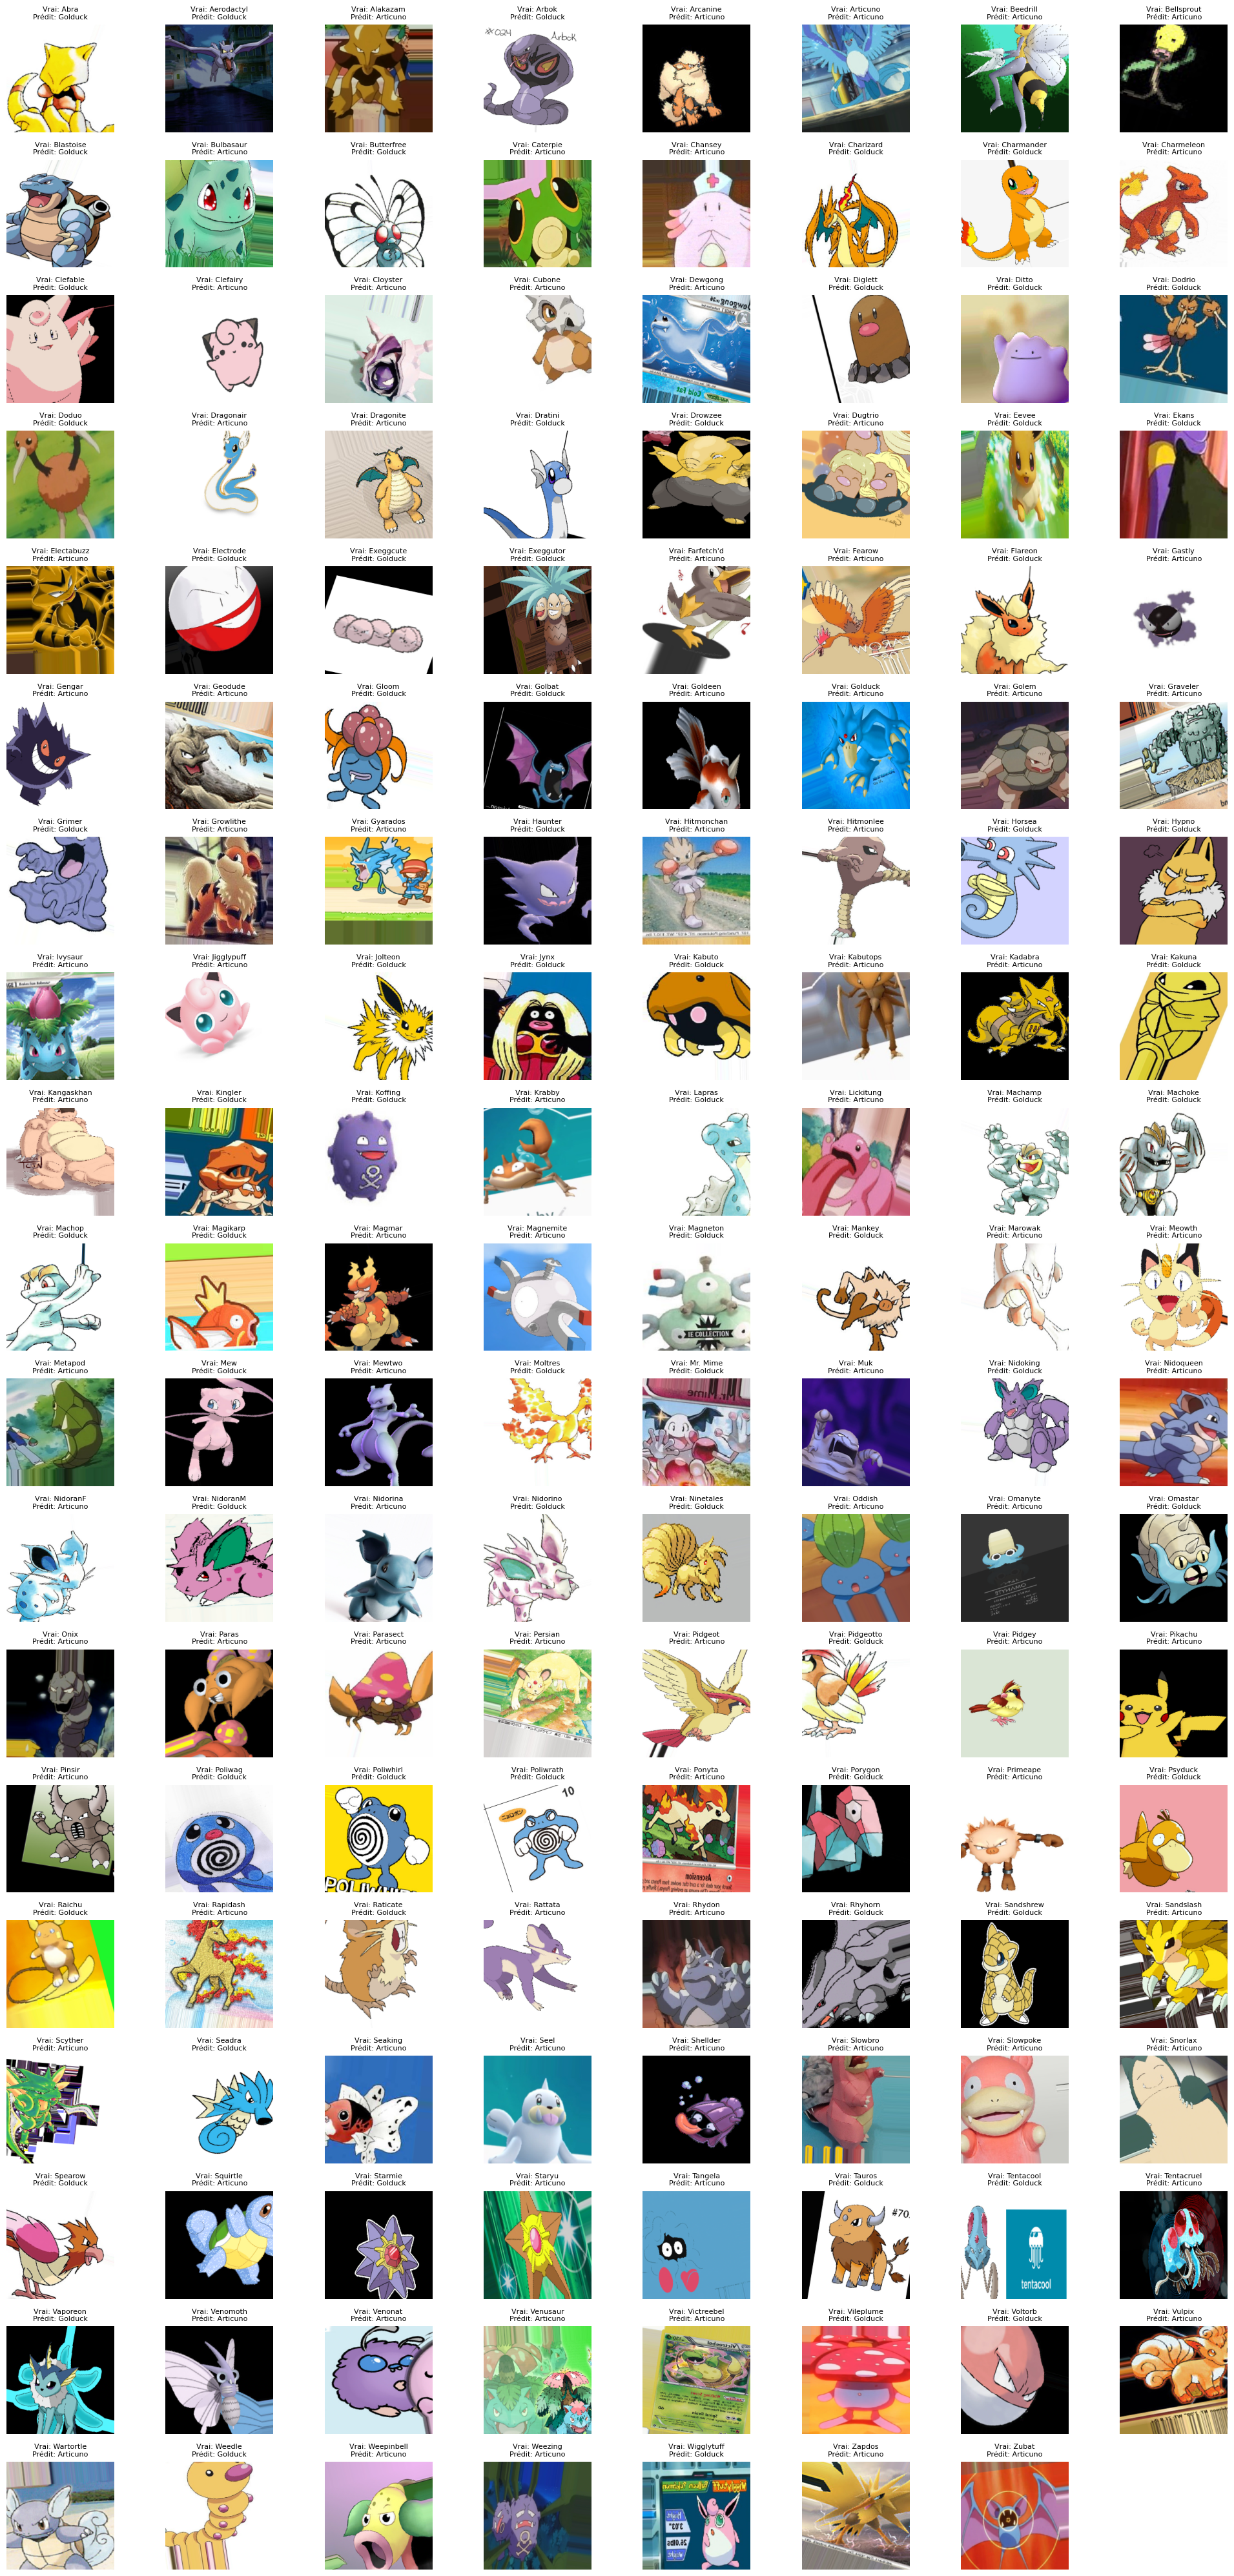

In [ ]:
# Obtenir une liste des noms de classes
class_names = list(train_generator.class_indices.keys())

# Afficher toutes les classes (151 classes)
num_classes_to_display = len(class_names)

# Initialiser one_image_per_class pour stocker les images
one_image_per_class = [None] * num_classes_to_display

# Boucle pour s'assurer d'avoir une image pour chaque classe
for i, class_index in enumerate(range(num_classes_to_display)):  # Itérer sur toutes les classes
    while one_image_per_class[i] is None:  # Tant qu'on n'a pas d'image pour cette classe
        x_train, y_train = next(train_generator)  # Obtenir un nouveau batch
        indices = np.where(np.argmax(y_train, axis=1) == class_index)[0]
        if indices.size > 0:
            random_index = np.random.choice(indices)
            one_image_per_class[i] = x_train[random_index]

# Définir la taille de la grille pour 151 images
num_rows = 19
num_cols = 8

# Afficher les images de toutes les classes avec les prédictions
plt.figure(figsize=(20, 40))  # Ajuster la taille de la figure
for i, class_index in enumerate(range(num_classes_to_display)):
    # Préparer l'image pour la prédiction
    image = np.expand_dims(one_image_per_class[i], axis=0)  # Ajouter une dimension batch
    prediction = model.predict(image)  # Prédiction du modèle
    predicted_class = class_names[np.argmax(prediction)]  # Obtenir le nom de la classe prédite

    # Afficher l'image
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(one_image_per_class[i])
    plt.title(f"Vrai: {class_names[class_index]}\nPrédit: {predicted_class}", fontsize=8)
    plt.axis('off')

plt.tight_layout()  # Ajuster l'espacement entre les subplots
plt.show()
